## 泰坦尼克乘客生存分析
数据集中的字段描述： 
PassengerId	乘客编号 
Survived	是否幸存 
Pclass	船票等级 
Name	乘客姓名 
Sex	乘客性别 
SibSp	亲戚数量（兄妹、配偶数） 
Parch	亲戚数量（父母、子女数） 
Ticket	船票号码 
Fare	船票价格 
Cabin	船舱 
Embarked	登录港口

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
# 魔法函数 内嵌画图，有了%matplotlib inline 就可以省掉plt.show()
#%matplotlib inline 
from sklearn.feature_extraction import DictVectorizer  # 处理符号化现象，将符号转化成数字0、1进行表示
from sklearn.tree import DecisionTreeClassifier  # 决策树
from sklearn.model_selection import cross_val_score # K折交叉验证

### 1、数据探索
** info（）了解数据表的基本情况：行数，列数，每列的数据类型，数据完整度

** describe（）了解数据表的统计情况：总数，平均值，标准差，最小值，最大值等

** describe（include = ['O']）里面是大写字母O，查看字符串类型（非数字）的整体情况

** 使用head查看前几行数据

** 使用tail查看后几行数据

In [2]:
# 数据加载
train_data = pd.read_csv('E:/Jupyter/算法/data/19.Titanic_Data-master/train.csv')
test_data = pd.read_csv('E:/Jupyter/算法/data/19.Titanic_Data-master/test.csv')
display(train_data.head())
display(test_data.tail())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


In [3]:
# 数据探索
display(train_data.info())   # 了解数据表的基本情况
print('-'*100)
display(train_data.describe()) # 了解数据表的统计情况
print('-'*100)
display(train_data.describe(include =['O']))  # 非数字字段

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


None

----------------------------------------------------------------------------------------------------


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


----------------------------------------------------------------------------------------------------


,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Toomey, Miss. Ellen",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


### 2、数据清洗
* 通过info可以看出训练集中Age、Cabin（船舱）、Embarked（登录港口）有缺失值，测试集中Age、Cabin有缺失值
* Age，Embarked有少量缺失值可补齐，但Cabin大量缺失值无法补齐

In [4]:
# 使用平均年龄来填充年龄中的nan值
train_data['Age'].fillna(train_data['Age'].mean(),inplace = True)
test_data['Age'].fillna(train_data['Age'].mean(),inplace = True)
train_data.info()
print(any(train_data['Age'].isnull()))  # 查看是否还有空值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
False


In [5]:
# Cabin有大量的缺失值，无法补齐。
# Embarked为登录港口，有少量缺失值，可以补齐
# 先观察Embarked字段的取值
display(train_data['Embarked'].value_counts())

# 三个登录港口中，S港口人数最多，把其余缺失的Embarked数值均设置为S
train_data['Embarked'].fillna('S',inplace = True)
test_data['Embarked'].fillna('S',inplace = True)
train_data.info()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 3、数据可视化
* 1、存活比例
* 2、年龄分布
* 3、年龄和船票等级与存活关系
* 4、男女存活情况
* 5、老人小孩存活情况

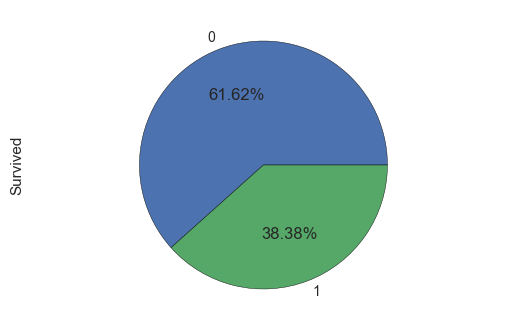

In [6]:
# 查看train_data存活比例
sns.set()
sns.set_style('darkgrid')
plt.axis('equal') # 避免比例压缩为椭圆
train_data['Survived'].value_counts().plot.pie(autopct = '%.2f%%')
plt.show()

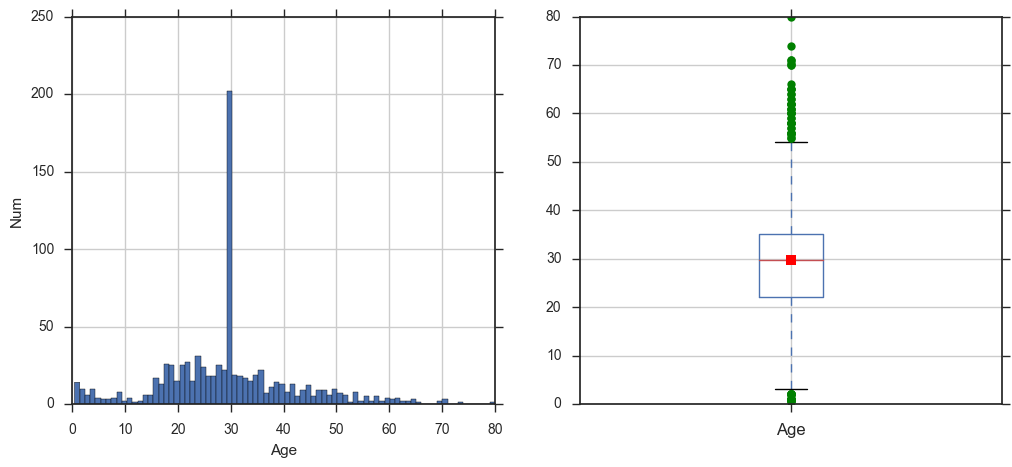

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64


In [7]:
# 年龄分布情况(直方图和箱型图表示)
sns.set()
sns.set_style('ticks')
plt.figure(figsize = (12,5))
plt.subplot(121)
train_data['Age'].hist(bins = 80)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_data.boxplot(column = 'Age',
                   showmeans=True,      # showmeans显示均值
                   showfliers = True,   # showfliers是否显示异常值,默认是True
                   flierprops = {"marker":"o","markerfacecolor":"Green"})
plt.show()
print(train_data['Age'].describe())

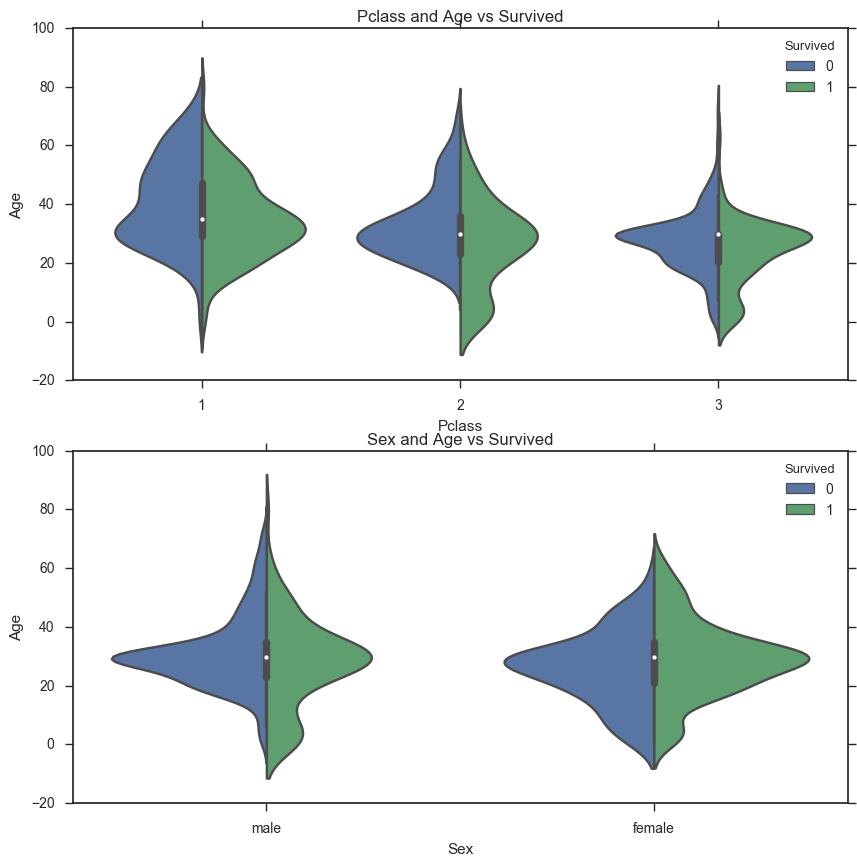

In [8]:
# 船票等级、年龄与存活的关系
fig,ax = plt.subplots(2,1,figsize = (10,10))  # 创建子图  Pclass船票等级分组
sns.violinplot('Pclass','Age',hue = 'Survived',data = train_data,split = True,ax = ax[0])
ax[0].set_title('Pclass and Age vs Survived')
#一等舱 集中分布在20--40岁
#二等舱 除了分布在20--40岁外，还有很多低龄存活者

# 性别、年龄与存活的关系
sns.violinplot('Sex','Age',hue = 'Survived',data = train_data,split = True,ax = ax[1])
ax[1].set_title('Sex and Age vs Survived')
#男性死亡人数比女性高，多数分布在20--40岁
#男性低龄存活者比女性低龄存活者人数要多
#男性老年存活者比女性老年存活者人数要少

plt.show()

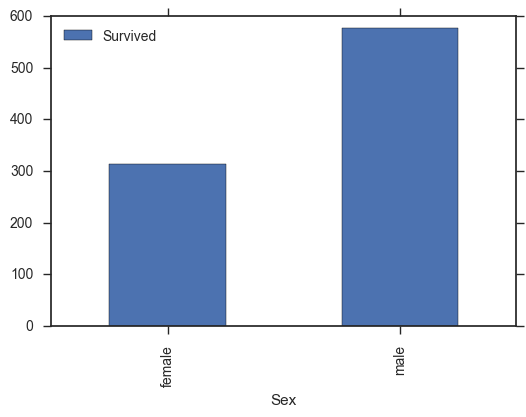

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64
女性存活率：74.20%
男性存活率：18.89%


In [9]:
# 男性和女性存活情况
train_data[['Sex','Survived']].groupby('Sex').count().plot.bar()
plt.show()
ss = train_data.groupby(['Sex','Survived'])['Survived'].count()
print(ss)
print('女性存活率：%.2f%%' %(ss.loc['female',1] / ss.loc['female'].sum()*100))
print('男性存活率：%.2f%%' %(ss.loc['male',1] / ss.loc['male'].sum()*100))

,Age_int,Survived
0,0,1.000000
1,1,0.714286
2,2,0.300000
3,3,0.833333
4,4,0.700000


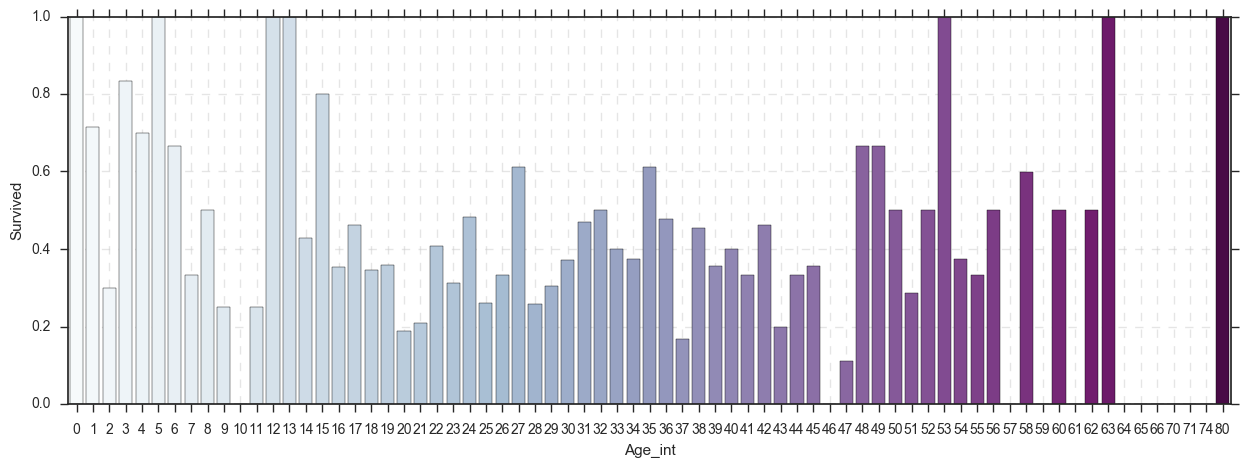

In [10]:
# 查看老人与小孩存活率
# 因为年龄不都是整数，所以需要调成整数格式
train_data['Age_int'] = train_data['Age'].astype(np.int)
# as_index = False代表把原本是index位置的Age_int放到作为列数据
avg_age = train_data[['Age_int','Survived']].groupby('Age_int',as_index = False).mean()  # 计算各年龄生还平均值
display(avg_age.head())

# 制作条形图
plt.figure(figsize = (15,5))
sns.barplot(x = 'Age_int',y = 'Survived',data = avg_age,palette='BuPu')
plt.grid(linestyle = '--',alpha = 0.5)
plt.show()
# 0-1岁，5-6岁的小孩存活率还是比较高的
# 老人也是比较高的
# 结合上面的图，20-40岁人数最多，但是存活率较低

### 结合SibSp、Parch字段，研究亲人多少与存活率的关系
* 1、有无兄弟姐妹、配偶/父母子女和存活与否的关系
* 2、亲人多少与存活与否的关系

有兄弟姐妹、配偶的人有： 283
无兄弟姐妹、配偶的人有： 608
有父母子女的人有： 213
无父母子女的人有： 678


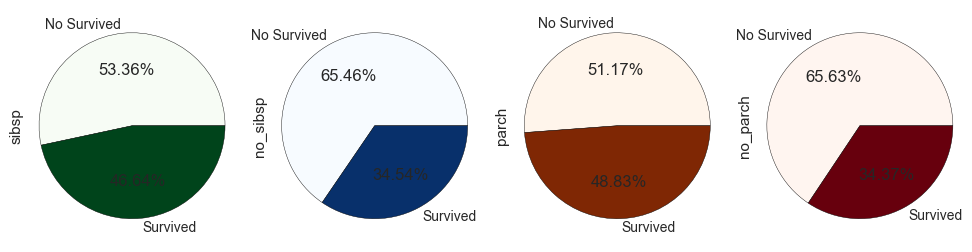

In [11]:
# 查看是否有兄弟姐妹、配偶
sibsp = train_data[train_data['SibSp'] != 0]    # 有兄弟姐妹、配偶
no_sibsp = train_data[train_data['SibSp'] == 0] # 无兄弟姐妹、配偶
print('有兄弟姐妹、配偶的人有：',len(sibsp))    
print('无兄弟姐妹、配偶的人有：',len(no_sibsp))

# 查看是否有父母子女
parch = train_data[train_data['Parch'] != 0]    # 有父母子女
no_parch = train_data[train_data['Parch'] == 0] # 无父母子女
print('有父母子女的人有：',len(parch))
print('无父母子女的人有：',len(no_parch))

# 图表可视化
plt.figure(figsize = (12,3))  # 12*3的大小，一行放4个图
plt.subplot(141)
plt.axis('equal')
sibsp['Survived'].value_counts().plot.pie(labels = ['No Survived','Survived'],autopct = '%.2f%%',colormap = 'Greens')
plt.ylabel('sibsp')

plt.subplot(142)
plt.axis('equal')
no_sibsp['Survived'].value_counts().plot.pie(labels = ['No Survived','Survived'],autopct = '%.2f%%',colormap = 'Blues')
plt.ylabel('no_sibsp')

plt.subplot(143)
plt.axis('equal')
parch['Survived'].value_counts().plot.pie(labels = ['No Survived','Survived'],autopct = '%.2f%%',colormap = 'Oranges')
plt.ylabel('parch')

plt.subplot(144)
plt.axis('equal')
no_parch['Survived'].value_counts().plot.pie(labels = ['No Survived','Survived'],autopct = '%.2f%%',colormap = 'Reds')
plt.ylabel('no_parch')

plt.show()
# 有兄弟姐妹、配偶和父母子女的存活率要更大一点

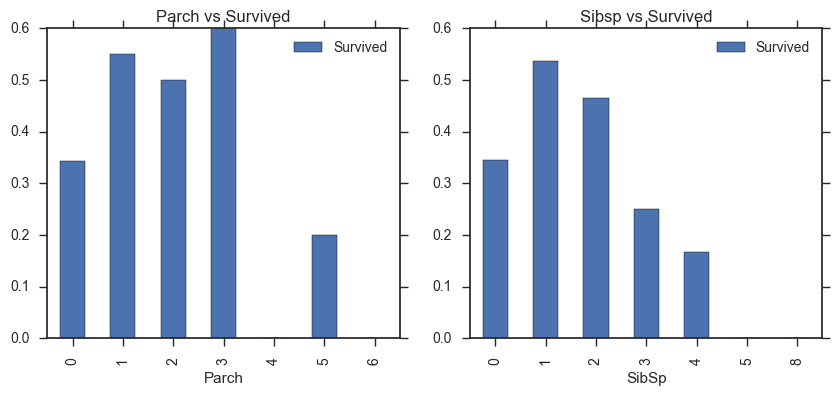

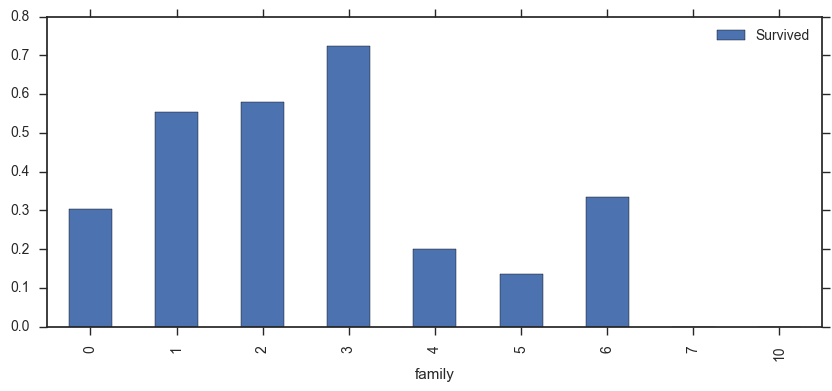

In [12]:
# 亲人多少与存活与否的关系
fig,ax = plt.subplots(1,2,figsize = (10,4))
train_data[['Parch','Survived']].groupby('Parch').mean().plot.bar(ax = ax[0])  # 计算各parch数量对应的存活率
ax[0].set_title('Parch vs Survived')

train_data[['SibSp','Survived']].groupby('SibSp').mean().plot.bar(ax = ax[1])
ax[1].set_title('Sibsp vs Survived')

# 没有父母子女的人存活率较低，有1-3个的存活率较高，但是多于3个又开始降低
# 没有兄弟姐妹、配偶的人存活率较低，有1-2个的存活率较高，但是有3个以上的存活率降低

# 把兄弟姐妹、配偶+父母子女统计在一起，查看与存活率的关系
train_data['family'] = train_data['Parch'] + train_data['SibSp']
train_data[['family','Survived']].groupby('family').mean().plot.bar(figsize = (10,4))

plt.show()

### 结合票的费用情况，研究票价和存活与否的关系
* 票价分布和存活与否的关系
* 比较生还者和未生还者的票价情况

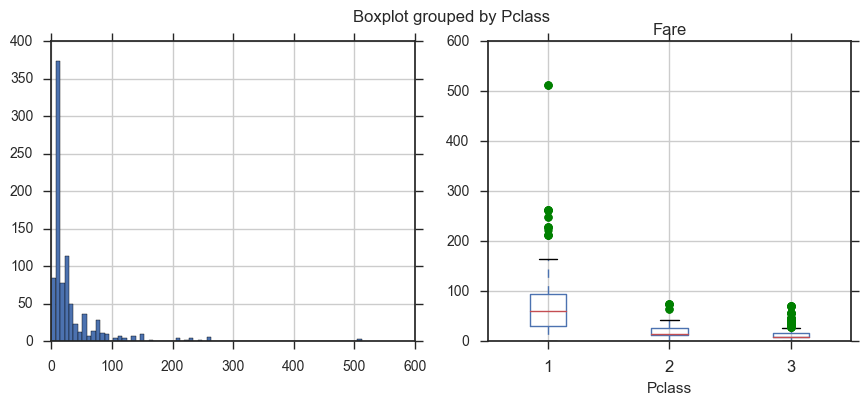

In [13]:
# 票价分布和存活与否的关系
fig,ax = plt.subplots(1,2,figsize = (10,4))
train_data['Fare'].hist(bins = 70,ax = ax[0])
train_data.boxplot(column = 'Fare',by = 'Pclass',ax = ax[1],flierprops = {"marker":"o","markerfacecolor":"Green"})
plt.show()
# 第一张图表示票价在50以内的数量占绝大多数
# 第二张图表示一等舱均价在60元，二等舱和三等舱均价在20元以下
# 结合两张图可以看出，一等舱票价高，但是人数比较少，二等舱和三等舱的人数比较多

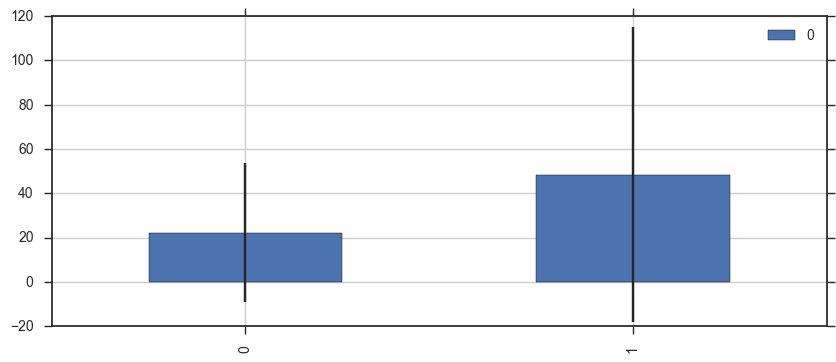

In [14]:
# 票价分布和存活与否的关系
# 筛选数据
fare_NoSurvived = train_data['Fare'][train_data['Survived'] == 0]  
fare_Survived = train_data['Fare'][train_data['Survived'] != 0]
avg_fare = pd.DataFrame([fare_NoSurvived.mean(),fare_Survived.mean()])
std_fare = pd.DataFrame([fare_NoSurvived.std(),fare_Survived.std()])

# 图表可视化
avg_fare.plot(yerr = std_fare,kind = 'bar',figsize = (10,4),grid = True)
plt.show()
# 生还者票价要大于非生还者票价
# 一等舱的存活率要高于二三等舱

## 泰坦尼克乘客生存预测

### 4、特征选择
* 特征选择是分类器的关键，特征选择不同，得到的分类器也不同
* 通过数据探索我们发现，PassengerId（乘客编号）、Name（姓名），对分类无作用，可以排除；Cabin（船舱）缺失值太多，排除；Ticket杂乱无章，排除。
* 其余字段：Pclass（船票等级）、Sex（性别）、Age（年龄）、SibSp（兄妹、配偶数）、Parch（父母、子女数）、Fare（船票价格）、Embarked（登录港口），可能会与乘客的生存预测分类相关。

In [15]:
# 把其余字段作为特征放到特征向量features里
features = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']
train_features = train_data[features]
train_labels = train_data['Survived']
train_features.head(10)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.000000,1,0,7.2500,S
1,1,female,38.000000,1,0,71.2833,C
2,3,female,26.000000,0,0,7.9250,S
3,1,female,35.000000,1,0,53.1000,S
4,3,male,35.000000,0,0,8.0500,S
5,3,male,29.699118,0,0,8.4583,Q
6,1,male,54.000000,0,0,51.8625,S
7,3,male,2.000000,3,1,21.0750,S
8,3,female,27.000000,0,2,11.1333,S
9,2,female,14.000000,1,0,30.0708,C


In [16]:
# 可以看到特征值sex和embarked是字符串，不方便后续运算，需要转成数值类型
# sex字段可以变成两个字段 sex = male 和 sex = female，用数值0或1来表示
# embarked有S\C\Q三种可能，也改成Embarked=S、Embarked=C、Embarked=Q三个字段，用数值0或1来表示

#train_features['Sex'] = train_features['Sex'].map({'male':0,'female':1}) #将sex = male转为0，sex = female转为1
# 或
"""train_features['Sex'][train_features['Sex'] == 'male'] = 0
train_features['Sex'][train_features['Sex'] == 'female'] = 1
train_features['Embarked'][train_features['Embarked'] == 'S'] = 0
train_features['Embarked'][train_features['Embarked'] == 'C'] = 1
train_features['Embarked'][train_features['Embarked'] == 'Q'] = 2"""

# 第二种方法
# 使用sklearn特征选择的DictVectorizer类，可以处理符号化现象，将符号转化成数字0、1进行表示
dvec = DictVectorizer(sparse = False)  #sparse=False意思是不产生稀疏矩阵

# fit_transform函数，可以将特征向量转化为特征值矩阵
train_features = dvec.fit_transform(train_features.to_dict(orient = 'record'))

# devc在转化后的特征属性通过feature_names_查看
print(dvec.feature_names_)

['Age', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Fare', 'Parch', 'Pclass', 'Sex=female', 'Sex=male', 'SibSp']


### 4、决策树模型
** 使用ID3算法，即在创建DecisionTreeClassifier时，设置criterion = 'entropy'

** 然后使用fit进行训练，将特征矩阵和分类标识结果作为参数传入，得到决策树分类器

In [17]:
# 构造ID3决策树
clf = DecisionTreeClassifier(criterion = 'entropy')
# 决策树训练
clf = clf.fit(train_features,train_labels)
clf

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### 5、模型预测&评估
** 在预测中，首先需要得到测试集的特征值矩阵，然后训练好的决策树clf进行预测，得到预测结果pred_labels

In [18]:
test_features = test_data[features]
test_features.info()
test_features.dropna(inplace = True)
print('-'*100)
test_features.info()
print('-'*100)

test_features = dvec.transform(test_features.to_dict(orient = 'record'))
print(dvec.feature_names_)

#test_features
# 代入测试集的特征值矩阵到决策树，得出预测结果
pred_labels = clf.predict(test_features)
#pred_labels

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 22.9+ KB
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 417
Data columns (total 7 columns):
Pclass      417 non-null int64
Sex         417 non-null object
Age         417 non-null float64
SibSp       417 non-null int64
Parch       417 non-null int64
Fare        417 non-null float64
Embarked    417 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 26.1+ KB
----------------------------------------------------------------------------------------------------
['Age', 'Embarked=

In [19]:
# 由于test.csv中没有实际的Survived结果，预测出来的pred_labels无法与之作比较评判准确率
# 只能使用训练集中的数据进行模型评估

# 得到决策树准确率
acc_decision_tree = clf.score(train_features,train_labels)
print('score准确率为：%.4f' %acc_decision_tree)
#用训练集做训练，在用训练集自身做准确率评估自然高，得出的准确率不能代表决策树分类器的准确率

score准确率为：0.9820


### 6、K折交叉验证方法：对于不知道测试集实际结果的，使用该方法才能知道模型的准确率
** 原理：拿出大部分样本进行训练，少量的用于分类器的验证。就是做K次交叉验证，每次选取K分之一的数据作为验证，其余作为训练，轮流K次，取平均值

** 1.将数据集平均分割成K个等分

** 2.使用1份数据作为测试数据，其余作为训练数据

** 3.计算测试准确率

** 4.使用不同的测试集，重复2和3步骤

** sklearn的 model_selection模型提供cross_val_score函数，函数中的参数cv代表对原始数据划分成多少份，也就是我们的K值，一般建议K值取10，因此可以设置CV = 10

In [20]:
# #cv：选择每次测试折数  accuracy：评价指标是准确度,可以省略使用默认值
cvs = cross_val_score(clf,train_features,train_labels,cv = 10,scoring='accuracy')
print(cvs)
print('准确率为%.4f' % np.mean(cvs))

[ 0.68888889  0.77777778  0.6741573   0.82022472  0.84269663  0.76404494
  0.83146067  0.74157303  0.84269663  0.84090909]
准确率为0.7824


## 总结：
### 1、特征选择时分类模型好坏的关键，选择什么特征，对应的特征值矩阵，决定了分类模型的好坏，通常情况下，特征值不都是数值类型，可以使用DictVectorizer类进行转化
### 2、模型准确率需要考虑是否有测试集的实际结果可以做对比，当测试集没有真实结果可以对比时，需要使用K折交叉验证cross_val_score
### 3、DictVectorizer类中提供fit_transform函数和transform函数，区别是：
* fit_transform()的作用是先拟合数据，然后将其转化为标准形式，一般应用在训练集中
* transform()是通过找中心和缩放等实现标准化，一般用在测试集中